In [47]:
# Python library and module imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py
import torch

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Import the custom plotting module
from plot_utils import plot_utils

# WatChMaL imports
from io_utils.data_handling_2 import WCH5Dataset

# PyTorch imports
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from collections import Counter 

### Check the raw .h5 file using h5py

In [4]:
path = "/fast_scratch/NuPRISM_4pi_full_tank_grid/out.h5"
f = h5py.File(path, 'r')

In [5]:
f.keys()

<KeysViewHDF5 ['angles', 'energies', 'event_data', 'event_ids', 'labels', 'positions', 'root_files']>

In [8]:
raw_angles = f["angles"]
raw_energies = f["energies"]
raw_event_ids = f["event_ids"]
raw_labels = f["labels"]
raw_positions = f["positions"]

print(len(raw_angles), len(raw_energies), len(raw_event_ids), len(raw_labels), len(raw_positions))

9000000 9000000 9000000 9000000 9000000


In [93]:
print(len(raw_positions))

9000000


### Use the watchmal WCH5Dataset handler to load the dataset

In [13]:
train_batch_size = 1024

In [96]:
dset=WCH5Dataset("/fast_scratch/NuPRISM_4pi_full_tank_grid/out.h5", 0.1, 0.1, reduced_dataset_size=1000000)

In [97]:
train_loader = DataLoader(dset, batch_size=train_batch_size, shuffle=False,
                          pin_memory=True, sampler=SubsetRandomSampler(dset.train_indices))

### Iterate over the dataset and collect the event, label, energy and angle data per example

In [99]:
labels = []
energies = []
angles = []
indices = []

for data in iter(train_loader):
    labels.append(data[1].numpy())
    energies.append(data[2].numpy())
    angles.append(data[3].numpy())
    indices.append(data[4].numpy())

In [ ]:
print(len(event_charges), event_charges[0].shape, len(event_timings), event_timings[0].shape)

In [100]:
print(len(labels), labels[0].shape,
      len(energies), energies[0].shape,
      len(angles), angles[0].shape,
      len(indices), indices[0].shape)

782 (1024,) 782 (1024, 1) 782 (1024, 2) 782 (1024,)


### Reshape the multi-dimensional arrays into shape = (num_examples, *)

In [45]:
event_charges = np.concatenate(event_charges, axis=0)
event_timings = np.concatenate(event_timings, axis=0)

In [101]:
labels   = np.concatenate(labels, axis=0)
energies = np.concatenate(energies, axis=0)
angles   = np.concatenate(angles, axis=0)
indices  = np.concatenate(indices, axis=0)

In [46]:
print(event_charges.shape, event_timings.shape)

(80000, 40, 40, 19) (80000, 40, 40, 19) (80000,) (80000, 1) (80000, 2) (80000,)


In [102]:
print(labels.shape, energies.shape, angles.shape, indices.shape)

(800000,) (800000, 1) (800000, 2) (800000,)


### Plot the distrbutions of the features from the dataset

### First check the distribution of the labels

In [103]:
print(Counter(labels))

Counter({1: 267189, 0: 266856, 2: 265955})


### Segment the event_charges, event_timings, energies, angles data using labels and plot their distributions

### Plot the per label energy distribution

In [104]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}

Text(0.5, 0, 'Energy (MeV)')

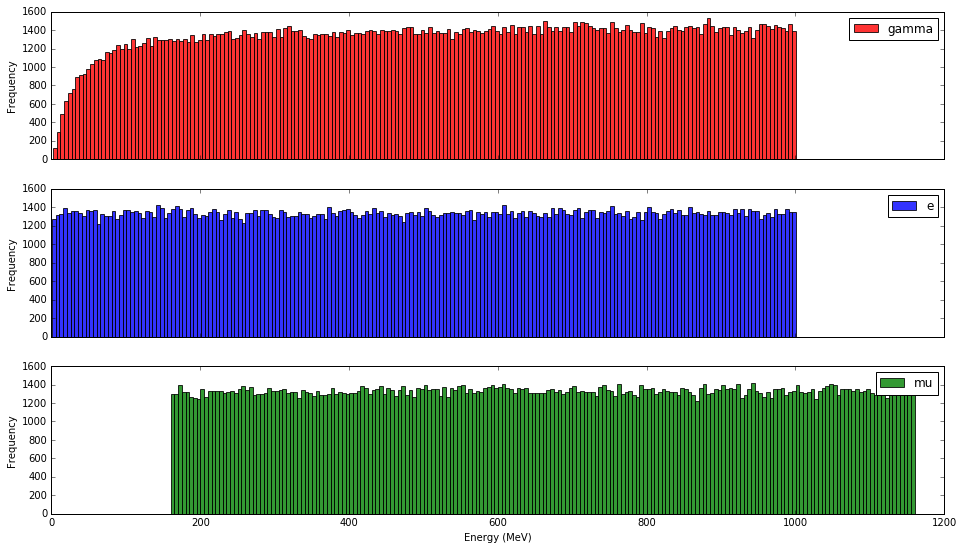

In [105]:
energies_dict = {}
for label in label_dict.keys():
    energies_dict[label] = energies[labels == label]
    
fig, axes = plt.subplots(3, 1, figsize=(16,9), sharex=True)

for label in energies_dict.keys():
    axes[label].hist(energies_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend()
    axes[label].set_ylabel("Frequency")
    
plt.xlabel("Energy (MeV)")

### Plot the per label angle distribution

Text(0.5, 0, 'Angle at index 0')

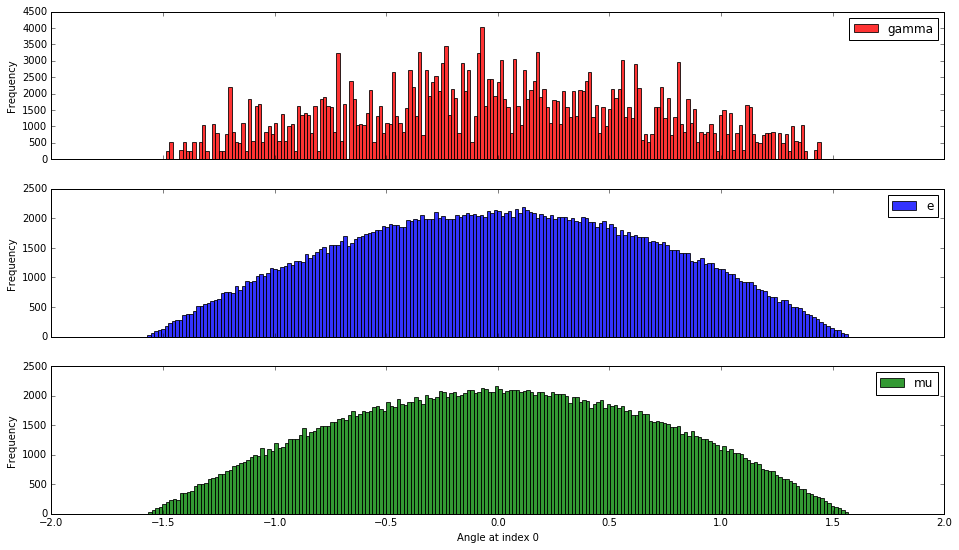

In [106]:
angles_0_dict = {}
for label in label_dict.keys():
    angles_0_dict[label] = angles[labels == label][:,0]
    
fig, axes = plt.subplots(3, 1, figsize=(16,9), sharex=True)

for label in angles_0_dict.keys():
    axes[label].hist(angles_0_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend()
    axes[label].set_ylabel("Frequency")
    
plt.xlabel("Angle at index 0")

Text(0.5, 0, 'Angle at index 1')

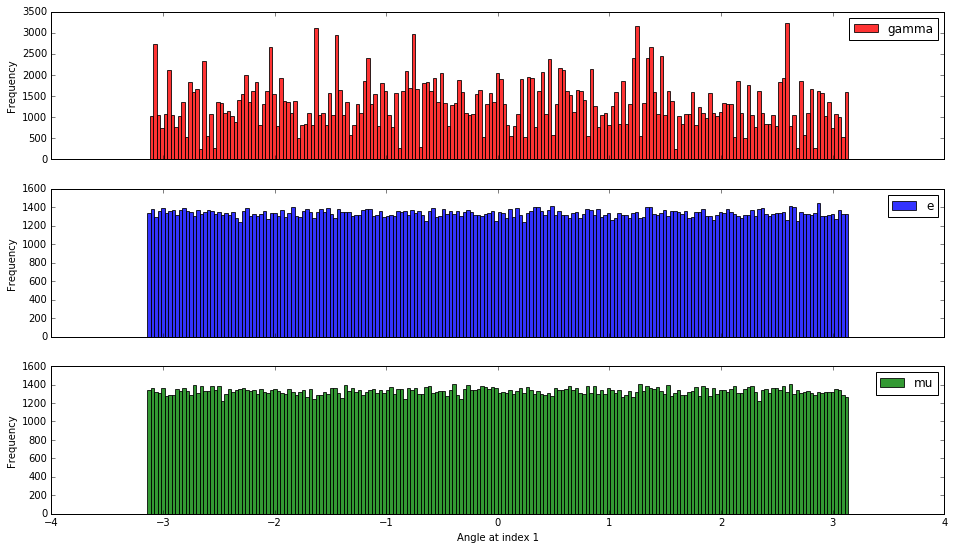

In [107]:
angles_1_dict = {}
for label in label_dict.keys():
    angles_1_dict[label] = angles[labels == label][:,1]
    
fig, axes = plt.subplots(3, 1, figsize=(16,9), sharex=True)

for label in angles_1_dict.keys():
    axes[label].hist(angles_1_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend()
    axes[label].set_ylabel("Frequency")
    
plt.xlabel("Angle at index 1")

### Plot the per label event charge distribution per mPMT module

In [108]:
event_charge_dict = {}
for label in label_dict.keys():
    event_charge_dict[label] = np.mean(event_charges[labels == label], axis=3).flatten()
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in angles_1_dict.keys():
    axes[label].hist(event_charge_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":20})
    axes[label].set_xlabel("Average charge per mPMT", fontsize=20)
    axes[label].set_ylabel("Frequency", fontsize=20)
    axes[label].tick_params(axis="both", labelsize=20)
    axes[label].set_yscale("log")
    axes[label].grid(True, which="both", axis="both")

TypeError: only integer scalar arrays can be converted to a scalar index

### Plot the per label event timing distribution per mPMT module

In [86]:
print(np.mean(event_timings[labels == label], axis=3).shape)

(26456, 40, 40)


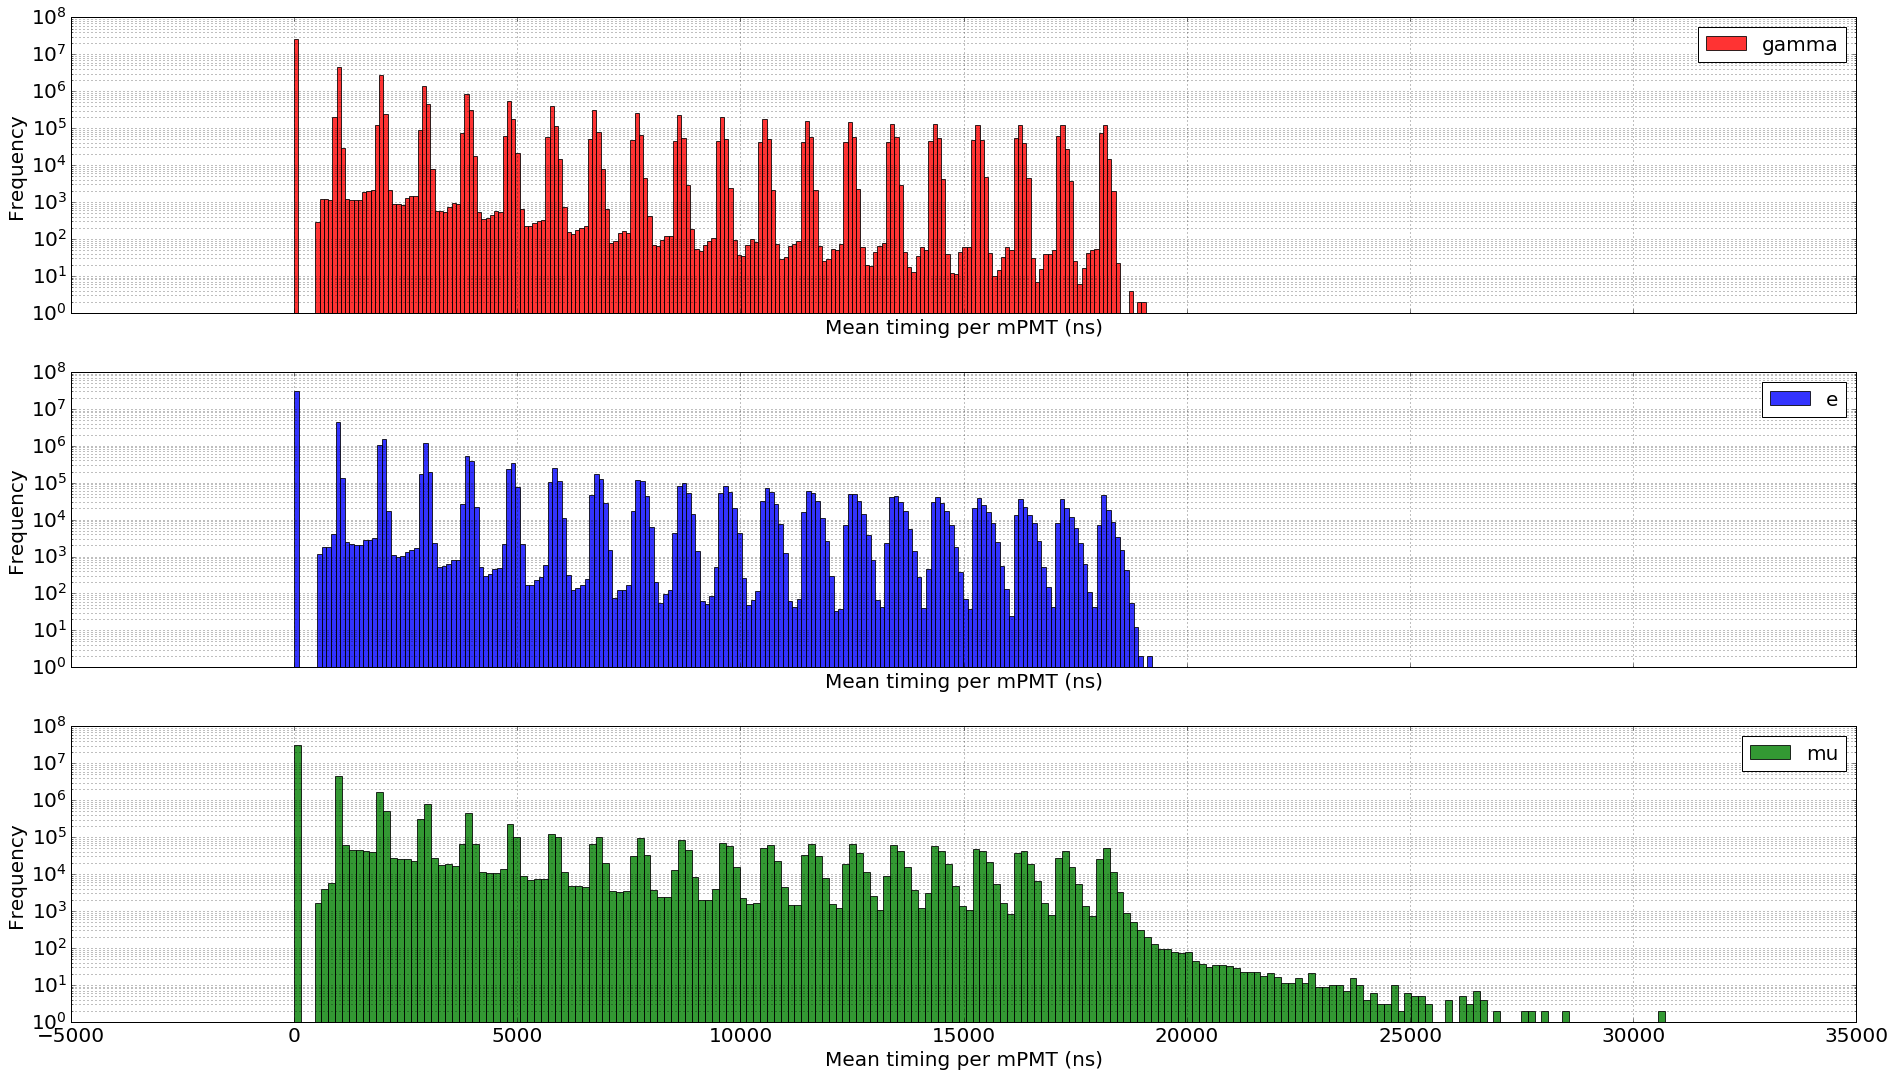

In [90]:
event_timing_dict = {}
for label in label_dict.keys():
    event_timing_dict[label] = np.sum(event_timings[labels == label], axis=3).flatten()
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in angles_1_dict.keys():
    axes[label].hist(event_timing_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":20})
    axes[label].set_xlabel("Mean timing per mPMT (ns)", fontsize=20)
    axes[label].set_ylabel("Frequency", fontsize=20)
    axes[label].tick_params(axis="both", labelsize=20)
    axes[label].set_yscale("log")
    axes[label].grid(True, which="both", axis="both")

### Plot the per label per PMT charge distribution

In [1]:
event_charge_dict = {}
for label in label_dict.keys():
    event_charge_dict[label] = event_charges[labels == label].flatten()
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in angles_1_dict.keys():
    axes[label].hist(event_charge_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":20})
    axes[label].set_xlabel("PMT Charge", fontsize=20)
    axes[label].set_ylabel("Frequency", fontsize=20)
    axes[label].tick_params(axis="both", labelsize=20)
    axes[label].set_yscale("log")
    axes[label].grid(True, which="both", axis="both")

NameError: name 'label_dict' is not defined

### Plot the per label per PMT timing distribution

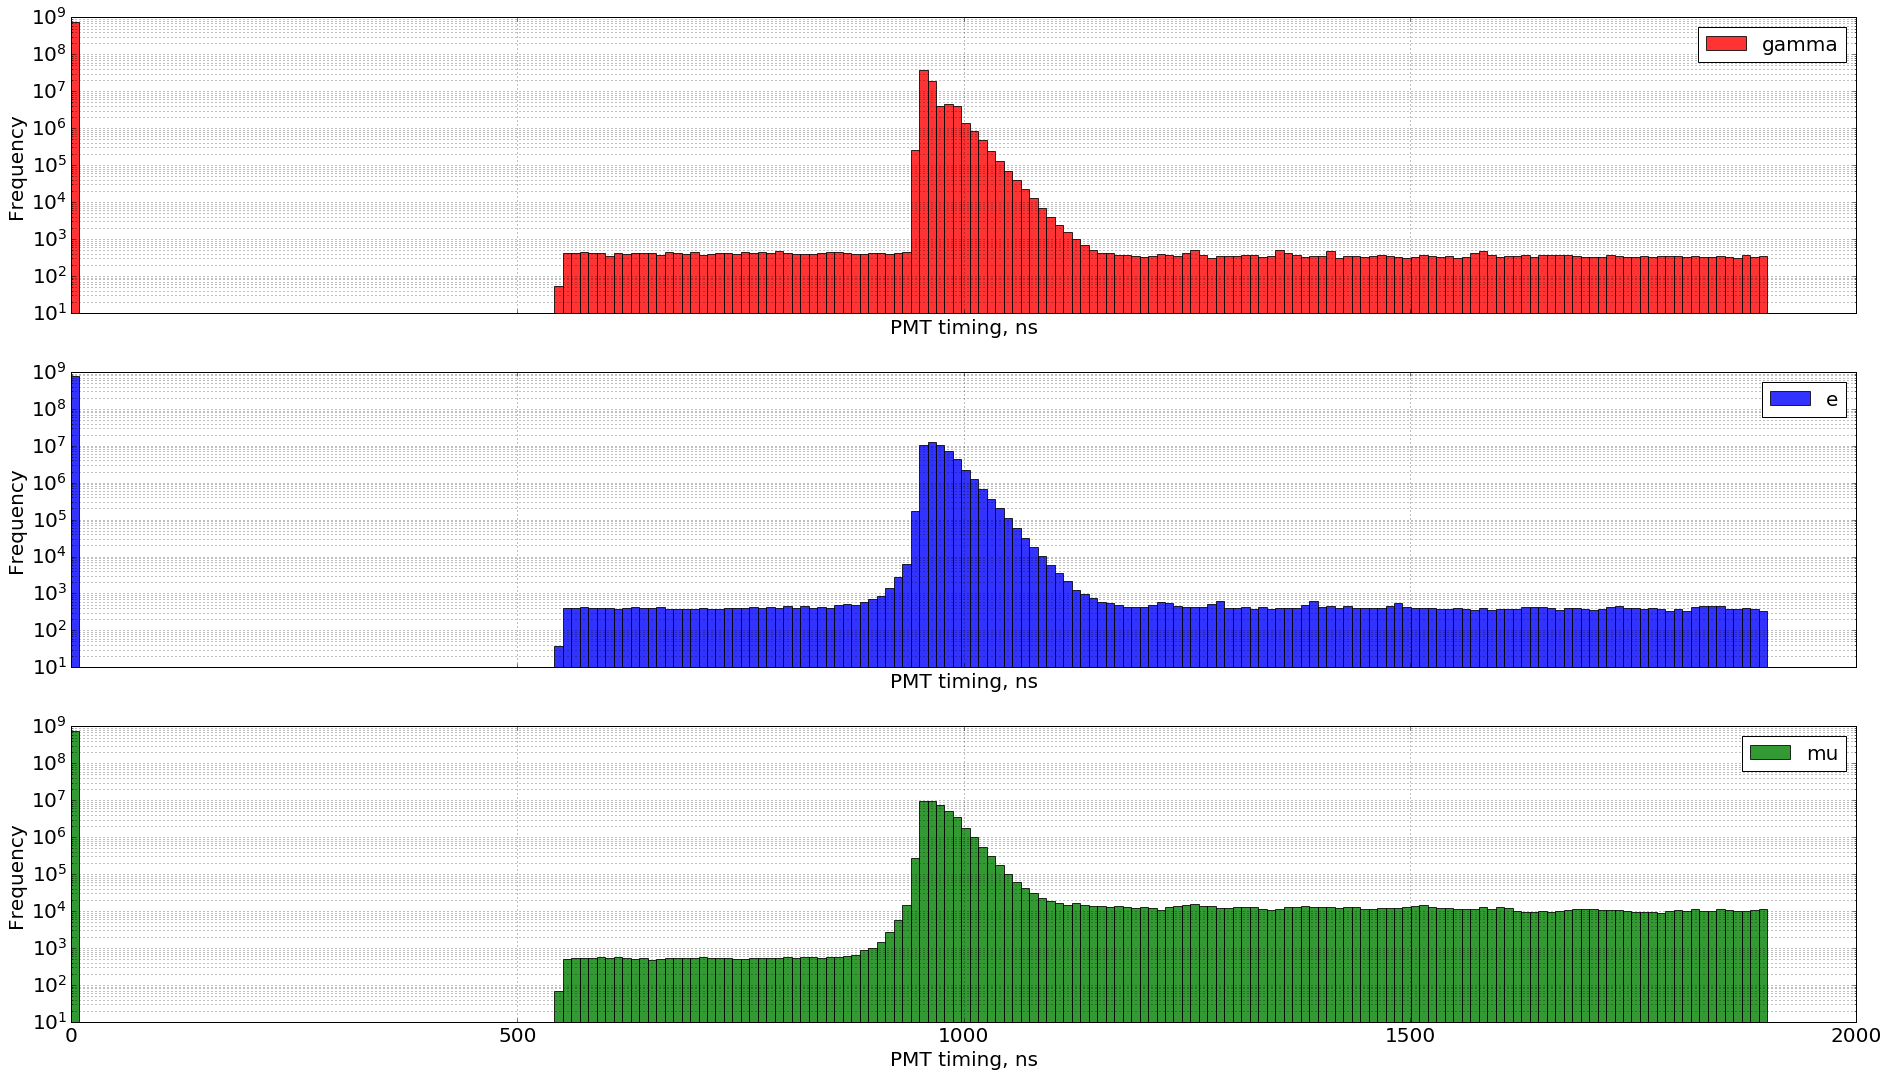

In [92]:
event_timing_dict = {}
for label in label_dict.keys():
    event_timing_dict[label] = event_timings[labels == label].flatten()
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in angles_1_dict.keys():
    axes[label].hist(event_timing_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":20})
    axes[label].set_xlabel("PMT timing, ns", fontsize=20)
    axes[label].set_ylabel("Frequency", fontsize=20)
    axes[label].tick_params(axis="both", labelsize=20)
    axes[label].set_yscale("log")
    axes[label].grid(True, which="both", axis="both")